## Importing packages and data

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.api import abline_plot
from statsmodels import graphics

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, accuracy_score, log_loss
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

import timeit
import time

import lazypredict

from lazypredict.Supervised import LazyClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', None)
pd.reset_option('width')
pd.set_option('display.expand_frame_repr', False)

In [223]:
train = pd.read_csv("C:/Users/feher/Documents/GitHub/Heart_disease_prediction/train.csv")
test = pd.read_csv("C:/Users/feher/Documents/GitHub/Heart_disease_prediction/test.csv")

for i in [train,test]:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                840 non-null    int64  
 1   age                  840 non-null    int64  
 2   sex                  840 non-null    int64  
 3   chest pain type      840 non-null    int64  
 4   resting bp s         840 non-null    int64  
 5   cholesterol          840 non-null    int64  
 6   fasting blood sugar  840 non-null    int64  
 7   resting ecg          840 non-null    int64  
 8   max heart rate       840 non-null    int64  
 9   exercise angina      840 non-null    int64  
 10  oldpeak              840 non-null    float64
 11  ST slope             840 non-null    int64  
 12  target               840 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 85.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (to

In [224]:
train.head()

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,0,72,1,2,136,209,1,0,111,1,-2.92,3,1
1,1,61,1,3,113,341,0,0,186,1,1.32,1,1
2,2,60,1,4,128,388,0,2,103,1,0.06,1,0
3,3,65,1,3,136,201,1,2,142,0,1.23,2,1
4,4,60,1,4,115,331,1,0,141,0,-0.16,1,0


### Let's check for null values

In [225]:
train.isnull().sum()

index                  0
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [226]:
test.isnull().sum()

index                  0
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
dtype: int64

## There are no null values, so let's check if the values in each variable make sense

### Let's see descriptive statistics

In [227]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,840.00,419.50,242.63,0.00,209.75,419.50,629.25,839.00
age,840.00,54.30,13.42,28.00,43.00,56.00,65.00,77.00
sex,840.00,0.73,0.45,0.00,0.00,1.00,1.00,1.00
chest pain type,840.00,3.23,1.06,0.00,2.00,4.00,4.00,4.00
resting bp s,840.00,133.45,26.46,0.00,115.00,132.00,148.50,200.00
cholesterol,840.00,258.32,87.61,0.00,195.75,248.00,310.00,603.00
fasting blood sugar,840.00,0.26,0.44,0.00,0.00,0.00,1.00,1.00
resting ecg,840.00,0.79,0.88,0.00,0.00,0.00,2.00,2.00
max heart rate,840.00,132.89,35.07,60.00,106.00,135.00,161.00,202.00
exercise angina,840.00,0.40,0.49,0.00,0.00,0.00,1.00,1.00


#### Findings
##### Chest pain type values should be 0, 1, 2 and 3  but there are 4's
##### A resting blood pressure of 200 seems really bad, but not impossible. I should check that out later.
##### A serum cholesterol of 603 is crazy high (200+ is high). Should check that out if data error
##### Slope (slope of the peak exercise ST segment (1—upsloping; 2—ﬂat; 3—downsloping)) has 4 categories instead of 3.

In [228]:
print(train.shape, '\n', test.shape)

(840, 13) 
 (360, 12)


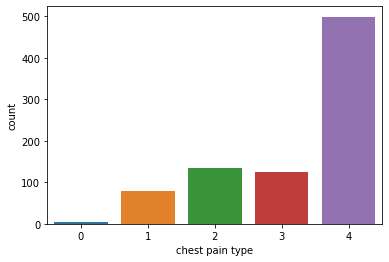

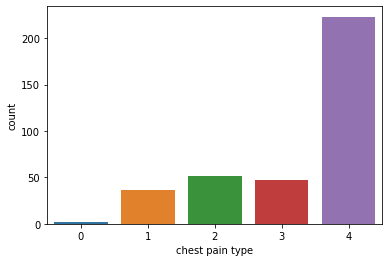

In [229]:
sns.countplot(x=train["chest pain type"])
plt.show()

sns.countplot(x=test["chest pain type"])
plt.show()

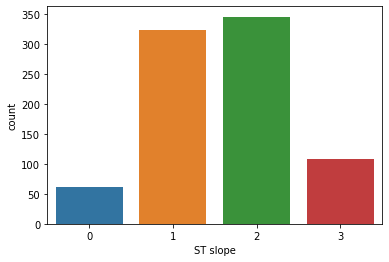

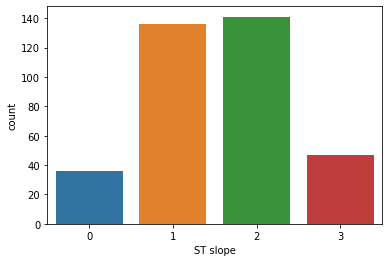

In [230]:
sns.countplot(x=train["ST slope"])
plt.show()

sns.countplot(x=test["ST slope"])
plt.show()

In [231]:
train.loc[train["chest pain type"] == 0]

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
246,246,44,1,0,116,183,0,2,125,0,1.52,2,1
305,305,69,0,0,148,233,0,0,163,0,-0.02,1,1
456,456,45,1,0,170,196,0,0,127,0,1.45,2,1
572,572,52,1,0,100,274,0,0,67,0,0.11,1,0
625,625,37,1,0,118,466,0,1,73,1,-0.01,0,0


In [232]:
test.loc[test["chest pain type"] == 0]

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
146,146,67,1,0,178,190,1,0,98,0,1.88,2
181,181,71,0,0,155,235,1,0,139,1,-0.03,1


In [233]:
train.loc[train["ST slope"] == 0]

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
46,46,67,1,3,102,187,0,0,154,1,-0.09,0,1
72,72,28,0,4,98,204,1,2,149,0,1.17,0,1
81,81,46,0,4,125,177,1,1,98,1,-2.29,0,1
104,104,56,1,1,138,142,1,0,172,0,-0.13,0,1
110,110,47,1,4,137,236,0,0,202,0,3.86,0,0
114,114,64,1,4,160,238,0,0,140,0,1.17,0,0
119,119,69,0,4,135,349,0,0,154,0,0.32,0,1
130,130,70,1,4,138,253,0,2,192,1,-0.03,0,1
155,155,72,1,4,100,216,0,0,67,1,-0.01,0,0
186,186,72,1,4,130,281,1,1,123,0,0.37,0,0


In [234]:
test.loc[test["ST slope"] == 0]

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
4,4,61,1,4,124,223,0,0,128,0,3.05,0
5,5,36,1,4,137,211,1,0,94,0,-0.01,0
20,20,77,1,2,132,157,0,1,150,0,-0.18,0
23,23,60,1,4,150,335,0,2,67,0,0.18,0
40,40,56,0,4,148,231,0,2,150,0,0.03,0
43,43,57,1,4,115,407,0,0,181,1,1.73,0
46,46,63,1,2,110,222,0,0,158,0,0.14,0
49,49,42,0,4,145,529,0,2,174,0,-0.14,0
53,53,60,0,4,110,184,0,2,123,1,0.50,0
91,91,59,1,4,100,340,0,0,108,0,-0.99,0


### Correlations

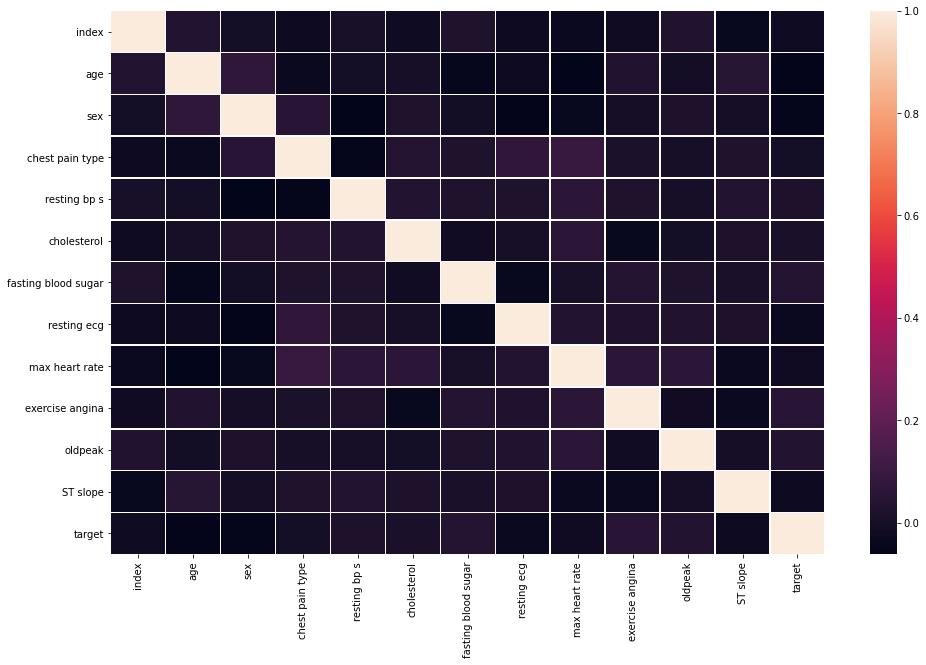

target                 1.00
exercise angina        0.05
fasting blood sugar    0.04
oldpeak                0.04
resting bp s           0.02
cholesterol            0.01
chest pain type       -0.01
max heart rate        -0.02
index                 -0.02
ST slope              -0.02
resting ecg           -0.04
sex                   -0.05
age                   -0.05
Name: target, dtype: float64


In [235]:
#Heatmap of the correlations
plt.figure(figsize=(16,10))
corr = train.corr()
sns.heatmap(corr, linewidths=.5)
plt.show()

#All variables seem to have a low correlation with the target
corr_sort = corr["target"].sort_values(ascending=False)
print(corr_sort)

### Encoding categorical vars

In [236]:
#### Recoding "chest pain type variable". 
#### As there are 5 rows with value 0 in the train set and 2 in the test set, I assume that these patients are asymptotic as well.
#### Recoding asymptotic to 0, so it becomes the baseline when we're dropping first during one hot encoding.

def my_recode(cpt):
    if cpt == 4:
        return 0
    else:
        return cpt



train["chest pain type"] = train["chest pain type"].apply(my_recode)
train.head()

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,0,72,1,2,136,209,1,0,111,1,-2.92,3,1
1,1,61,1,3,113,341,0,0,186,1,1.32,1,1
2,2,60,1,0,128,388,0,2,103,1,0.06,1,0
3,3,65,1,3,136,201,1,2,142,0,1.23,2,1
4,4,60,1,0,115,331,1,0,141,0,-0.16,1,0


In [237]:
test["chest pain type"] = train["chest pain type"].apply(my_recode)
test.head()

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,0,65,0,2,185,131,0,0,160,1,0.76,2
1,1,60,1,3,124,157,0,0,102,1,0.58,2
2,2,32,1,0,120,306,0,1,100,0,-0.14,3
3,3,76,1,3,105,220,1,0,169,0,0.84,1
4,4,61,1,0,124,223,0,0,128,0,3.05,0


In [238]:
#### Recoding "ST slope". 
#### Converting ST slope to 3 where it is 0

def st_slope_recode(st_slope):
    if st_slope == 0:
        return 3
    else:
        return st_slope

train["ST slope"] = train["ST slope"].apply(st_slope_recode)
train.head()

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,0,72,1,2,136,209,1,0,111,1,-2.92,3,1
1,1,61,1,3,113,341,0,0,186,1,1.32,1,1
2,2,60,1,0,128,388,0,2,103,1,0.06,1,0
3,3,65,1,3,136,201,1,2,142,0,1.23,2,1
4,4,60,1,0,115,331,1,0,141,0,-0.16,1,0


In [239]:
test["ST slope"] = test["ST slope"].apply(st_slope_recode)
test.head()

,index,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,0,65,0,2,185,131,0,0,160,1,0.76,2
1,1,60,1,3,124,157,0,0,102,1,0.58,2
2,2,32,1,0,120,306,0,1,100,0,-0.14,3
3,3,76,1,3,105,220,1,0,169,0,0.84,1
4,4,61,1,0,124,223,0,0,128,0,3.05,3


In [240]:
categorical_columns = ["sex", "chest pain type", "fasting blood sugar", "resting ecg", "exercise angina", "ST slope"]
columns_to_encode = ["chest pain type", "resting ecg", "ST slope"]

ohe = OneHotEncoder(drop = 'first', sparse=False)

ohe.fit(train[columns_to_encode])

OneHotEncoder(drop='first', sparse=False)

In [241]:
ohe.categories_

[array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2], dtype=int64),
 array([1, 2, 3], dtype=int64)]

In [242]:
train_ohed = pd.DataFrame(ohe.transform(train[columns_to_encode]))
test_ohed = pd.DataFrame(ohe.transform(test[columns_to_encode]))

train_ohed.index = train.index
test_ohed.index = test.index

numeric_train = train.drop(columns_to_encode, axis=1)
numeric_test = test.drop(columns_to_encode, axis=1)

In [243]:
test_ohed.head()

,0,1,2,3,4,5,6
0,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2,0.00,0.00,0.00,1.00,0.00,0.00,1.00
3,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [244]:
train_ohed = train_ohed.set_axis(['Chest_pain_typ_angina', 'Chest_pain_atyp_angina', 'Chest_pain_nonang', \
                                  'resting_ecg_stt_abnormal', 'resting_ecg_lvh', \
                                  'ST_slope_flat', 'ST_slope_down'], axis=1, inplace=False)


test_ohed = test_ohed.set_axis(['Chest_pain_typ_angina', 'Chest_pain_atyp_angina', 'Chest_pain_nonang', \
                                  'resting_ecg_stt_abnormal', 'resting_ecg_lvh', \
                                  'ST_slope_flat', 'ST_slope_down'], axis=1, inplace=False)


In [245]:
new_train = pd.concat([numeric_train, train_ohed], axis=1)
new_test = pd.concat([numeric_test, test_ohed], axis=1)

new_train.head()

,index,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,Chest_pain_typ_angina,Chest_pain_atyp_angina,Chest_pain_nonang,resting_ecg_stt_abnormal,resting_ecg_lvh,ST_slope_flat,ST_slope_down
0,0,72,1,136,209,1,111,1,-2.92,1,0.00,1.00,0.00,0.00,0.00,0.00,1.00
1,1,61,1,113,341,0,186,1,1.32,1,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,2,60,1,128,388,0,103,1,0.06,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,3,65,1,136,201,1,142,0,1.23,1,0.00,0.00,1.00,0.00,1.00,1.00,0.00
4,4,60,1,115,331,1,141,0,-0.16,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Model building

In [246]:
X = new_train.drop(['target', 'index'] , axis = 1)
y = new_train['target']
X_train , X_test , y_train , y_test = train_test_split(X, 
                                                       y, 
                                                       random_state = 42,
                                                       test_size = 0.33)

In [247]:
clf = LazyClassifier(verbose=0,
                    ignore_warnings=True,
                    custom_metric=None)

models, predictions = clf.fit(X_train , X_test , y_train , y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 22.27it/s]


In [248]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.55,0.55,0.55,0.55,0.02
QuadraticDiscriminantAnalysis,0.55,0.55,0.55,0.55,0.02
BernoulliNB,0.55,0.54,0.54,0.52,0.02
LGBMClassifier,0.54,0.53,0.53,0.53,0.07
ExtraTreesClassifier,0.53,0.53,0.53,0.53,0.17
LinearDiscriminantAnalysis,0.54,0.53,0.53,0.51,0.02
RidgeClassifierCV,0.54,0.52,0.52,0.51,0.01
RidgeClassifier,0.54,0.52,0.52,0.51,0.02
LogisticRegression,0.54,0.52,0.52,0.51,0.02


In [249]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

### Hyperparameter tuning

#### Decision Tree Classifier

In [250]:
start = timeit.default_timer()

dtc_clf = DecisionTreeClassifier()

max_depth_list = np.linspace(1, 32, 32, endpoint=True)
min_samples_split_list = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_list = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_list = list(range(1,train.shape[1]))


parameters = {
    "max_depth": max_depth_list,
    "min_samples_split": min_samples_split_list,
    "min_samples_leaf": min_samples_leaf_list,
    "max_features": max_features_list
    }

#Evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Random search procedure
random_search = RandomizedSearchCV(estimator = dtc_clf, param_distributions = parameters, cv = cv, n_iter = 10, n_jobs = -1)

#Executing the random search
random_result = random_search.fit(X_train, y_train)

#Best score and configuration
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_)) 

#Runtime
stop = timeit.default_timer()

print("Hyperparameter tuning runtime:", stop - start)

Best: 0.547985 using {'min_samples_split': 0.30000000000000004, 'min_samples_leaf': 0.5, 'max_features': 10, 'max_depth': 13.0}
Hyperparameter tuning runtime: 5.15048840000054


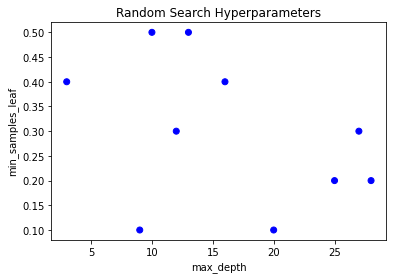

In [251]:
rand_x = list(random_result.cv_results_['param_max_depth'])
rand_y = list(random_result.cv_results_['param_min_samples_leaf'])

x_lims = [np.min(max_depth_list), np.max(learn_rate_list)]
y_lims = [np.min(min_samples_leaf_list), np.max(n_estimators_list)]

plt.scatter(rand_x, rand_y, c=['blue']*10)
plt.gca().set(xlabel='max_depth', ylabel='min_samples_leaf',title='Random Search Hyperparameters')

plt.show()

In [252]:
start = timeit.default_timer()

dtc_clf = DecisionTreeClassifier()

max_depth_list = np.linspace(1, 32, 32, endpoint=True)
min_samples_split_list = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_list = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_list = list(range(1,train.shape[1]))


parameters = {
    "max_depth": max_depth_list,
    "min_samples_split": min_samples_split_list,
    "min_samples_leaf": min_samples_leaf_list,
    "max_features": max_features_list
    }

#Evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Random search procedure
grid_search = GridSearchCV(estimator = dtc_clf, param_grid = parameters, cv = cv, n_jobs = -1)

#Executing the random search
grid_result = grid_search.fit(X_train, y_train)

#Best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

#Runtime
stop = timeit.default_timer()

print("Hyperparameter tuning runtime:", stop - start)

Best: 0.554511 using {'max_depth': 14.0, 'max_features': 5, 'min_samples_leaf': 0.30000000000000004, 'min_samples_split': 0.2}
Hyperparameter tuning runtime: 480.97017660000165


#### LGBM Classifier

In [263]:
start = timeit.default_timer()

lgbm_clf = LGBMClassifier()

parameters = {
    "learning_rate": sp_randFloat(),
    "max_depth":sp_randInt(4, 10),
    "subsample": sp_randFloat(),
    "n_estimators":sp_randInt(10,1000)
    }

#Evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

#Random search procedure
random_search = RandomizedSearchCV(estimator = lgbm_clf, param_distributions = parameters, cv = cv, n_iter = 10, n_jobs = -1)

#Executing the random search
random_result = random_search.fit(X_train, y_train)

#Best score and configuration
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_)) 

#Runtime
stop = timeit.default_timer()

print("Hyperparameter tuning runtime:", stop - start)

Best: 0.503592 using {'learning_rate': 0.00400464764137376, 'max_depth': 4, 'n_estimators': 207, 'subsample': 0.7813511100554869}
Hyperparameter tuning runtime: 15.45049250000011


## Running the models

In [253]:
new_test.shape

(360, 16)

In [254]:
X_valid = new_test.drop(['index'], axis = 1)
y_valid = np.empty([new_test.shape[0],], dtype=bool)

In [257]:
dtc_clf = DecisionTreeClassifier(max_depth = 14,
                               max_features = 5,
                               min_samples_leaf = 0.30000000000000004,
                               min_samples_split = 0.2)

dtc_clf.fit(X_train, y_train)

predictions = dtc_clf.predict(X_test)

accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]

print("DecisionTreeClassifier accuracy: %f" % (accuracy))

dtc_pred_val = dtc_clf.predict(X_valid)

DecisionTreeClassifier accuracy: 0.525180


In [264]:
lgbm_clf = LGBMClassifier(learning_rate = 0.00400464764137376, 
                            max_depth = 4, 
                            n_estimators = 207, 
                            subsample = 0.7813511100554869,
                            seed = 42)

lgbm_clf.fit(X_train, y_train)

predictions = lgbm_clf.predict(X_test)

accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]

print("Light gradient boosting accuracy: %f" % (accuracy), "\n", \
      "Feature Importances", "\n", pd.DataFrame(zip(X_test.columns, lgbm_clf.feature_importances_)))

lgbm_pred_val = lgbm_clf.predict(X_valid)

Light gradient boosting accuracy: 0.525180 
 Feature Importances 
                            0    1
0                        age  166
1                        sex   11
2               resting bp s  226
3                cholesterol  240
4        fasting blood sugar    0
5             max heart rate  241
6            exercise angina   95
7                    oldpeak  450
8      Chest_pain_typ_angina    0
9     Chest_pain_atyp_angina    1
10         Chest_pain_nonang   55
11  resting_ecg_stt_abnormal    0
12           resting_ecg_lvh  101
13             ST_slope_flat    0
14             ST_slope_down   18


In [265]:
submission = pd.read_csv("sample_submission.csv")

submission["target"] = dtc_pred_val.astype('int64')
submission.to_csv("submission.csv", index=False)
submission.head(15)

,index,target
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


In [262]:
X_valid

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,Chest_pain_typ_angina,Chest_pain_atyp_angina,Chest_pain_nonang,resting_ecg_stt_abnormal,resting_ecg_lvh,ST_slope_flat,ST_slope_down
0,65,0,185,131,0,160,1,0.76,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,60,1,124,157,0,102,1,0.58,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2,32,1,120,306,0,100,0,-0.14,0.00,0.00,0.00,1.00,0.00,0.00,1.00
3,76,1,105,220,1,169,0,0.84,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,61,1,124,223,0,128,0,3.05,0.00,0.00,0.00,0.00,0.00,0.00,1.00
5,36,1,137,211,1,94,0,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,1.00
6,74,0,172,388,1,67,0,0.09,0.00,1.00,0.00,0.00,0.00,0.00,0.00
7,51,1,172,200,1,145,1,0.32,0.00,0.00,1.00,1.00,0.00,0.00,0.00
8,34,1,145,394,0,168,1,1.35,0.00,0.00,1.00,1.00,0.00,1.00,0.00
9,75,1,105,269,0,100,1,-0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
